In [1]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Set CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
class OxfordPetsDataset(Dataset):
    def __init__(self, root_dir, split='train', mode='classification', transform=None, split_ratio=0.8, seed=42):
        assert mode == 'classification', "Only classification mode is supported here."

        self.root_dir = root_dir
        self.mode = mode
        self.split = split

        # Get all image base filenames (without extension)
        all_files = sorted([f[:-4] for f in os.listdir(os.path.join(root_dir, 'images')) if f.endswith('.jpg')])

        # Train/test split
        random.seed(seed)
        random.shuffle(all_files)
        split_idx = int(len(all_files) * split_ratio)
        self.image_ids = all_files[:split_idx] if split == 'train' else all_files[split_idx:]

        # Class name to index mapping
        self.class_names = sorted(list(set([img_id.rsplit('_', 1)[0] for img_id in all_files])))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}

        # Image transforms
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((384, 384)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root_dir, 'images', f'{img_id}.jpg')

        image = Image.open(img_path).convert('RGB')
        class_name = img_id.rsplit('_', 1)[0]
        label = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
# Load a single image to test dataset functionality
dataset = OxfordPetsDataset(root_dir='.', split='train', mode='classification')
image, label = dataset[0]

# Show info
print(f"Image shape: {image.shape}")
print(f"Label index: {label}, Label name: {dataset.class_names[label]}")


Image shape: torch.Size([3, 384, 384])
Label index: 31, Label name: samoyed


In [4]:
from torch.utils.data import DataLoader

# Create train and test datasets
train_dataset = OxfordPetsDataset(root_dir='.', split='train', mode='classification')
test_dataset = OxfordPetsDataset(root_dir='.', split='test', mode='classification')

# Store dataset sizes for throughput calculation
train_size = len(train_dataset)
test_size = len(test_dataset)
print(f"Train size: {train_size}, Test size: {test_size}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


Train size: 5912, Test size: 1478


In [5]:
import timm
import torch.nn as nn

# Load pretrained Swin Transformer, adjust for 37 classes
model = timm.create_model('swin_base_patch4_window12_384', pretrained=True, num_classes=37)
model = model.to(device)  # Ensure it uses CUDA


In [6]:
import torch.nn as nn
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Move loss function to device
criterion = criterion.to(device)


In [7]:
from tqdm import tqdm
import time
import torch

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()
    loop = tqdm(dataloader, desc="Training", leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    epoch_time = time.time() - start_time
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, epoch_time


In [8]:
import time

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()

    with torch.no_grad():
        loop = tqdm(dataloader, desc="Validation", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    epoch_time = time.time() - start_time
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, epoch_time


In [9]:
# Move model to CUDA (redundant if already done earlier, but safe to repeat)
model = model.to(device)

num_epochs = 5
history = []  # To store (train_loss, train_acc, val_loss, val_acc, train_time, val_time)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training
    train_loss, train_acc, train_time = train(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_acc, val_time = validate(model, test_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")
    print(f"Train Time: {train_time:.2f}s, Val Time: {val_time:.2f}s\n")

    # Save all metrics
    history.append((train_loss, train_acc, val_loss, val_acc, train_time, val_time))


Epoch 1/5


Train Loss: 0.5453, Train Acc: 84.12%
Val Loss:   0.2521, Val Acc:   91.81%
Train Time: 152.18s, Val Time: 13.36s

Epoch 2/5


Train Loss: 0.1783, Train Acc: 94.20%
Val Loss:   0.2053, Val Acc:   93.71%
Train Time: 110.90s, Val Time: 13.37s

Epoch 3/5


Train Loss: 0.1041, Train Acc: 96.68%
Val Loss:   0.3278, Val Acc:   91.81%
Train Time: 110.95s, Val Time: 13.37s

Epoch 4/5


Train Loss: 0.1088, Train Acc: 96.60%
Val Loss:   0.3270, Val Acc:   91.47%
Train Time: 110.97s, Val Time: 13.49s

Epoch 5/5


Train Loss: 0.0617, Train Acc: 98.07%
Val Loss:   0.2512, Val Acc:   93.17%
Train Time: 111.03s, Val Time: 13.42s



In [10]:
# Save trained model
save_path = "swin-B-384_pets_classifier.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to swin-B-384_pets_classifier.pth


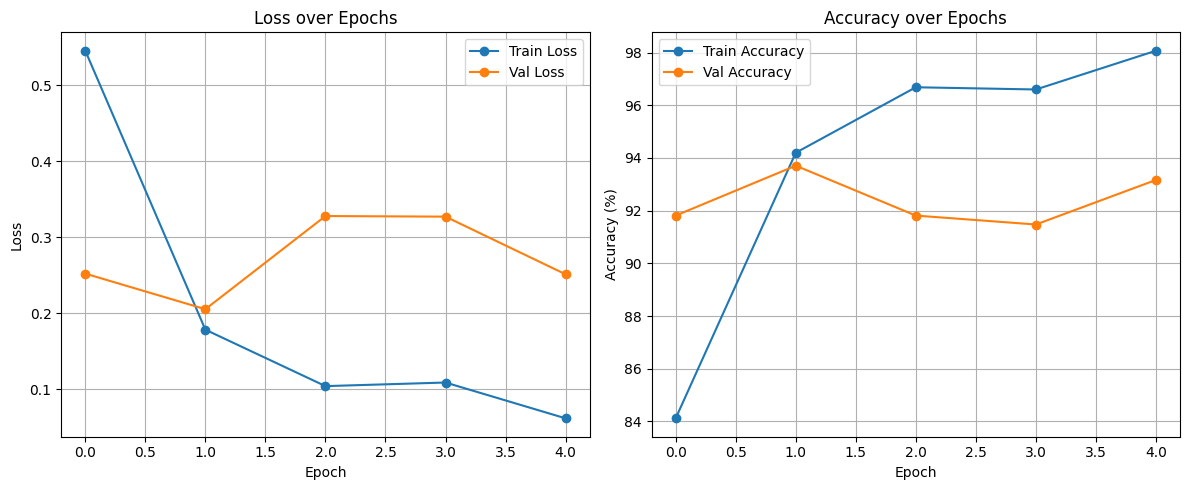

In [11]:
import matplotlib.pyplot as plt

# Unpack all 6 elements from history
train_losses, train_accuracies, val_losses, val_accuracies, train_times, val_times = zip(*history)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
import torch
import time
import timm
import warnings
import contextlib
import io
from fvcore.nn import FlopCountAnalysis, parameter_count_table
from tabulate import tabulate

# 1. Define input
sample_input = torch.randn(1, 3, 384, 384).to(device)

# 2. Params and FLOPs (suppress warnings and stderr)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with contextlib.redirect_stderr(io.StringIO()):
        flops = FlopCountAnalysis(model, sample_input)
        total_flops = flops.total() / 1e9  # GFLOPs
        param_table = parameter_count_table(model, max_depth=1)
        total_params = sum(p.numel() for p in model.parameters()) / 1e6  # M

# 3. Throughput
@torch.no_grad()
def measure_throughput(model, device, num_iters=100):
    model.eval()
    dummy_input = torch.randn(1, 3, 384, 384).to(device)
    for _ in range(10):  # warm-up
        _ = model(dummy_input)
    start = time.time()
    for _ in range(num_iters):
        _ = model(dummy_input)
    end = time.time()
    return num_iters / (end - start)

throughput = measure_throughput(model, device)

# 4. Top-1 Accuracy (from history)
_, _, _, val_accuracies, _, _ = zip(*history)
top1_acc = max(val_accuracies)

# 5. Build table
table_data = [[
    'Swin-B (384)',
    '384×384',
    f'{total_params:.1f}M',
    f'{total_flops:.2f}G',
    f'{throughput:.2f}',
    f'{top1_acc:.2f}%',
]]

headers = ['method', 'image size', '#params', 'FLOPs', 'throughput (img/s)', 'ImageNet top-1 acc.']
print(tabulate(table_data, headers=headers, tablefmt='github'))


| method       | image size   | #params   | FLOPs   |   throughput (img/s) | ImageNet top-1 acc.   |
|--------------|--------------|-----------|---------|----------------------|-----------------------|
| Swin-B (384) | 384×384      | 86.9M     | 47.19G  |                 54.5 | 93.71%                |
